In [2]:
!pip install datasets
!pip install clean-text
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:0

In [4]:
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import re
from cleantext import clean
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import numpy as np

# Dataset

In this part we read the dataset and we plot the distributions of the labels and the length of all the texts. 
We are dealing with a small dataset containing conspiratorial texts.

In [5]:
dataset = pd.read_csv("../datasets/subtaskB_train.csv")
dataset = dataset.drop('Id', axis=1)
dataset = dataset.drop('topic', axis=1)
dataset = dataset.rename(columns={'comment_text': 'text', 'conspiracy': 'label'})
dataset

,text,label
0,"Siamo davanti ad una prova, e non solo di quoz...",1
1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,0
2,L'avete capito che non toglieranno il green pa...,0
3,Quindi la farsa dello spazio e della terra a ...,3
4,"In breve tempo, per accedere a Internet, sarà ...",1
...,...,...
805,"Incredibile!!!! EMA, Agenzia Europea del Farma...",0
806,Non ci saranno colloqui di pace con la Russia ...,2
807,"L'atmosfera è uno ""scudo protettivo"" che avvol...",3
808,OTTIMA NOTIZIA! Due ragioni per cui le élite n...,0


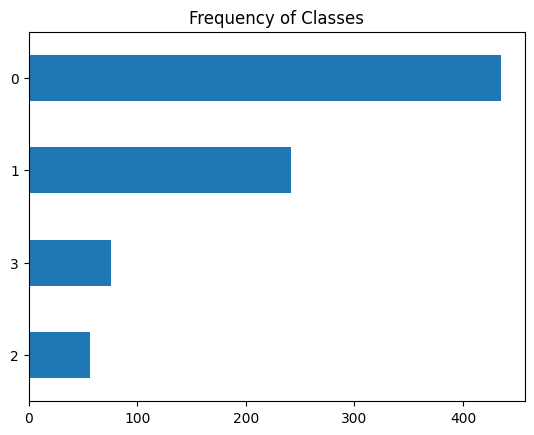

In [6]:
dataset['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

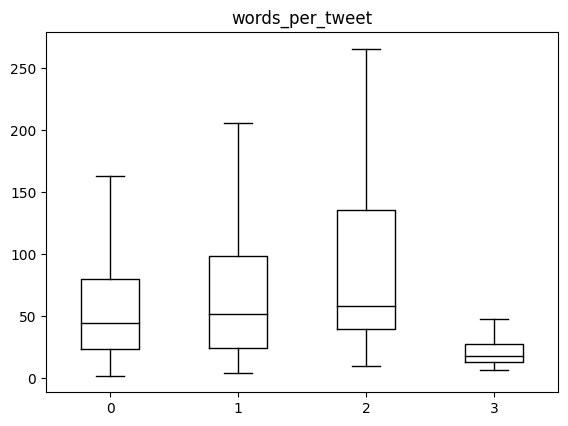

In [ ]:
dataset['words_per_tweet'] = dataset['text'].str.split().apply(len)
dataset.boxplot('words_per_tweet', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

dataset = dataset.drop('words_per_tweet', axis=1)

# Text Cleaning

In this section, first of all, we define the function that we will use to clean our text. As we can se above there are some texts between parentesis that are usefull and also unicodes.
We are removing all that stuff creating a text that is similar to the ones used to train the pre-trained model. So, for instance, we won't remove the punctuation and and stopwords.

In [7]:
# We define the function for the cleaning of the text

def text_cleaning(text):
    # Convert words to lower case
    text = text.lower()
    text = clean(text, no_emoji=True)

    text = re.sub(r'(\[.*?\])', '', text)
    text = re.sub(r'[0-9]{2}\/[0-9]{2}\/[0-9]{2,4}', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'[_"\()|+&=*%#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\.+','.', text)
    text = re.sub(r'\,+',',', text)
    text = re.sub(r'\!+','!', text)
    text = re.sub(r'\?+','?', text)
    text = re.sub(r'\n+','', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    return text

In [8]:
dataset['text'] = list(map(text_cleaning, dataset.text))
dataset

,text,label
0,"siamo davanti ad una prova, e non solo di quoz...",1
1,la storia dei 2 bimbi di bergamo - vaccini: qu...,0
2,l'avete capito che non toglieranno il green pa...,0
3,quindi la farsa dello spazio e della terra a p...,3
4,"in breve tempo, per accedere a internet, sara ...",1
...,...,...
805,"incredibile! ema, agenzia europea del farmaco,...",0
806,non ci saranno colloqui di pace con la russia ...,2
807,l'atmosfera e uno scudo protettivo che avvolge...,3
808,ottima notizia! due ragioni per cui le elite n...,0


# Model download

In this part we are downloading the bert-model and it's tokenizer from the hugging face hub.
In that specific case we will use the bert multilingual model

In [9]:
model_name = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [11]:
# We controll if the device support the computation on the GPU, otherwise we will compute the model on the CPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')

num_labels = 4  # Number of classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

## Metrics
We define the metric that we want to calculate during the fine-tuning of the model

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {'f1_score': f1}

In [14]:
from huggingface_hub import notebook_login
notebook_login()

In [13]:
def createDataset(train, val):
  tds = Dataset.from_pandas(train)
  vds = Dataset.from_pandas(val)
  dataset_hf = DatasetDict()
  
  dataset_hf['train'] = tds
  dataset_hf['validation'] = vds
  dataset_hf['train']= dataset_hf['train'].remove_columns("__index_level_0__")
  dataset_hf['validation']= dataset_hf['validation'].remove_columns("__index_level_0__")

  return dataset_hf

## Cross-Validation

Now we will define the cross validation to find the best hyperparameters of the model. This since we have a very small dataset, so we are trying to generalize as much as possible.

In [16]:
import random

lr_rates = [2e-5, 3e-5]
epochs = [2,3,4]
lr_scheduler = ['constant']

log_results_cross = pd.DataFrame({
    'learning_rate': [],
    'epochs': [],
    'f1_score': [],
    'lr_scheduler': []
})

# Define a custom collator function with dynamic masking
def collate_fn(batch):
    input_ids = [example['input_ids'] for example in batch]
    labels = [example['label'] for example in batch]

    # Apply dynamic masking
    for i in range(len(input_ids)):
        # Generate a random mask
        mask = [0] * len(input_ids[i])
        for j in range(len(input_ids[i])):
            if random.random() < 0.15:
                mask[j] = 1

        # Apply the mask to the input sequence
        input_ids[i] = [input_ids[i][j] if not mask[j] else tokenizer.mask_token_id for j in range(len(input_ids[i]))]

    # Pad the input sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(input_ids[i]) for i in range(len(input_ids))],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    # Create the input dictionary
    inputs = {'input_ids': input_ids, 'attention_mask': input_ids != tokenizer.pad_token_id, 'labels': torch.tensor(labels)}

    return inputs

for lr in lr_rates:
  for epoch in epochs:
    for scheduler in lr_scheduler:
      results = []

      for i in range(5):
        # We create the split of the dataset, shuffling before the data
        train, val = train_test_split(dataset, train_size=0.8, shuffle=True)
        df = createDataset(train, val)
        texts_encoded = df.map(tokenize, batched=True, batch_size=None)

        # We define the argument that the model has to use
        batch_size = 8
        logging_steps = len(texts_encoded['train'])
        model_name_hub = f'{model_name}-kcross'
        training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=epoch,
                                    learning_rate=lr,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    #lr_scheduler_type=scheduler,
                                    fp16=True,
                                    push_to_hub=False,
                                    log_level='error')
        # Train of the model
        trainer = Trainer(model=model,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=texts_encoded['train'],
                    eval_dataset=texts_encoded['validation'],
                    data_collator=collate_fn,
                    tokenizer=tokenizer)
        trainer.train()
        results.append(trainer.predict(texts_encoded['validation']).metrics['test_f1_score'])
    
    # We calculate the mean of the f1_scores and we save the model and the result on a log
    mean_f1_score = sum(results) / len(results)
    print(mean_f1_score)

    # We log the actual parameters and the mean f1_score
    parameters = [lr, epoch, mean_f1_score, scheduler]
    log_results_cross.loc[len(log_results_cross)] = parameters
  
log_results_cross.to_csv('/log/log_prova2.csv')

Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.659594,0.690038
2,No log,0.563278,0.834520


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.430323,0.836562
2,No log,0.475706,0.871189


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.622966,0.844770
2,No log,0.556807,0.881978


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.942512,0.830648
2,No log,0.849154,0.861832


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.083273,0.835305
2,No log,1.269156,0.843167


0.8436131459158046


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.186210,0.837510
2,No log,1.098848,0.866201
3,No log,0.879849,0.877075


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.712357,0.843552
2,No log,1.253577,0.870272
3,No log,1.293821,0.854259


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.398995,0.852474
2,No log,1.277914,0.852901
3,No log,1.011637,0.875013


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.433216,0.882061
2,No log,2.465761,0.796392
3,No log,1.443193,0.877335


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.825976,0.845885
2,No log,1.927359,0.856974
3,No log,1.773234,0.867045


0.8528010983268535


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.691529,0.875770
2,No log,1.949687,0.869560
3,No log,2.140554,0.853906
4,No log,1.642332,0.869711


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.849121,0.864880
2,No log,2.092410,0.856513
3,No log,1.783035,0.856946
4,No log,1.426141,0.876322


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.110573,0.850042
2,No log,2.009676,0.861667
3,No log,2.182793,0.849819
4,No log,2.038348,0.850215


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.342582,0.835099
2,No log,2.416686,0.850221
3,No log,2.238837,0.844817
4,No log,2.376195,0.836800


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.244527,0.839056
2,No log,2.608390,0.815570
3,No log,2.058076,0.844054
4,No log,1.913482,0.850756


0.8505458479399071


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.132964,0.864097
2,No log,2.131023,0.849874


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.132084,0.850679
2,No log,2.196439,0.849874


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.184819,0.850679
2,No log,2.225672,0.849874


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.209940,0.850679
2,No log,2.242846,0.849874


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.227205,0.850679
2,No log,2.255509,0.849874


0.8588936857276435


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.244361,0.850679
2,No log,2.270332,0.849874
3,No log,2.136173,0.857624


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.166944,0.862350
2,No log,2.278320,0.849315
3,No log,2.147673,0.857624


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.176504,0.862350
2,No log,2.294161,0.849315
3,No log,2.159155,0.857624


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.185057,0.862350
2,No log,2.304552,0.849315
3,No log,2.170145,0.857624


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.193573,0.862350
2,No log,2.313112,0.849315
3,No log,2.180125,0.857624


0.8492079467321012


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.201189,0.862350
2,No log,2.327072,0.849315
3,No log,2.193358,0.857624
4,No log,2.062903,0.862071


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.192591,0.861739
2,No log,2.368984,0.847999
3,No log,2.344574,0.843569
4,No log,2.177395,0.862978


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.233281,0.863525
2,No log,2.414448,0.849367
3,No log,2.467262,0.843569
4,No log,2.222449,0.856227


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.282136,0.861739
2,No log,2.361151,0.855117
3,No log,2.482289,0.843569
4,No log,2.241718,0.856227


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.300233,0.861739
2,No log,2.370061,0.855117
3,No log,2.492094,0.837106
4,No log,2.254145,0.862071


0.8469681874189978


# Train final Model

Now that we finished the cross-validation, we take the best model found and we buil the final model.
Then, we push the model into the hugging face hub

In [17]:
train, val = train_test_split(dataset, train_size=0.8, shuffle=True)
dataset_final_train = createDataset(train, val)
dataset_final_encoded = dataset_final_train.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/648 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

In [18]:
# We take the best parameter from the log
idx_best_model = log_results_cross['f1_score'].idxmax()
learning_rate_best = log_results_cross['learning_rate'][idx_best_model]
epoch_best = float(log_results_cross['epochs'][idx_best_model])
#lr_scheduler_best = log_results_cross['lr_scheduler'][idx_best_model]

print(f'The learning rate of the best model is: {learning_rate_best}')
print(f'The number of epochs of the best model is: {epoch_best}')

# We define the arguments for the training 
batch_size = 8
logging_steps = len(dataset_final_encoded['train'])
model_name_hub = 'prova-multi-multi'

# We train the final model
training_args = TrainingArguments(output_dir=model_name_hub,
                                  num_train_epochs=epoch_best,
                                  learning_rate=learning_rate_best,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #lr_scheduler_type=lr_scheduler_best,
                                  fp16=True,
                                  push_to_hub=True,
                                  log_level='error')

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_final_encoded['train'],
                  eval_dataset=dataset_final_encoded['validation'],
                  data_collator=collate_fn,
                  tokenizer=tokenizer)
trainer.train()
trainer.push_to_hub()

The learning rate of the best model is: 3e-05
The number of epochs of the best model is: 2.0


Cloning https://huggingface.co/Mike00vito/prova-multi-multi into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,2.311840,0.861739
2,No log,2.377247,0.855117


Upload file pytorch_model.bin:   0%|          | 1.00/638M [00:00<?, ?B/s]

Upload file runs/May06_10-05-06_deb4dfd717d4/events.out.tfevents.1683367511.deb4dfd717d4.208.62:   0%|        …

Upload file training_args.bin:   0%|          | 1.00/3.68k [00:00<?, ?B/s]

Upload file runs/May06_10-05-06_deb4dfd717d4/1683367511.8333673/events.out.tfevents.1683367511.deb4dfd717d4.20…

To https://huggingface.co/Mike00vito/prova-multi-multi
   fe8d1ec..42c7ed2  main -> main

   fe8d1ec..42c7ed2  main -> main

To https://huggingface.co/Mike00vito/prova-multi-multi
   42c7ed2..31851ab  main -> main

   42c7ed2..31851ab  main -> main



'https://huggingface.co/Mike00vito/prova-multi-multi/commit/42c7ed28b15a849ae9a2f7087252060cf679e51e'